# Week 8: Advection Equation - Advanced Explicit Methods

This notebook covers numerical methods for solving the advection equation using FTCS, Lax, and Lax-Wendroff schemes.

## 1. The Advection Equation

The advection equation (also called the linear convection equation) describes the evolution of a passive scalar field carried by flow with constant velocity $c$:

$$\frac{\partial a}{\partial t} = -c\frac{\partial a}{\partial x}$$

### Discretization

**Spatial grid:** spacing $h$, denoted by index $i$
- Position: $x_i = ih - L/2$
- Grid spacing: $h = L/(N-1)$ (for Dirichlet BC) or $h = L/N$ (for periodic BC)

**Time grid:** spacing $\tau$, denoted by index $n$
- Time: $t_n = n\tau$

**Field notation:** $a_i^n = a(x_i, t_n)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Numerical Methods

### 2.1 FTCS (Forward Time, Centered Space)

**Time derivative:** Forward difference
$$\frac{\partial a}{\partial t} = \frac{a_i^{n+1} - a_i^n}{\tau}$$

**Space derivative:** Centered difference
$$\frac{\partial a}{\partial x} = \frac{a_{i+1}^n - a_{i-1}^n}{2h}$$

**Update equation:**
$$a_i^{n+1} = a_i^n - \frac{c\tau}{2h}(a_{i+1}^n - a_{i-1}^n)$$

**Note:** FTCS is unconditionally unstable for advection!

### 2.2 Lax Method

Replace $a_i^n$ with the average of its neighbors:
$$a_i^n = \frac{1}{2}(a_{i+1}^n + a_{i-1}^n)$$

**Update equation:**
$$a_i^{n+1} = \frac{1}{2}(a_{i+1}^n + a_{i-1}^n) - \frac{c\tau}{2h}(a_{i+1}^n - a_{i-1}^n)$$

**Stability:** Stable if $|c\tau/h| \leq 1$ (CFL condition)

### 2.3 Lax-Wendroff Method

Uses Taylor expansion in time through second order:
$$a(x,t+\tau) = a(x,t) + \tau\frac{\partial a}{\partial t} + \frac{\tau^2}{2}\frac{\partial^2 a}{\partial t^2} + O(\tau^3)$$

**Update equation:**
$$a_i^{n+1} = a_i^n - \frac{c\tau}{2h}(a_{i+1}^n - a_{i-1}^n) + \frac{c^2\tau^2}{2h^2}(a_{i+1}^n + a_{i-1}^n - 2a_i^n)$$

**Optimal stability:** $\tau = \tau_{\max} = h/c$ (makes Lax-Wendroff = Lax)

### 2.4 Upwind Method

Uses backward difference when $c > 0$:
$$a_i^{n+1} = a_i^n - \frac{c\tau}{h}(a_i^n - a_{i-1}^n)$$

**Stability:** Stable if $0 \leq c\tau/h \leq 1$

## 3. Implementation

In [2]:
def solve_advection(method, N, L, c, tau, nStep):
    """
    Solve advection equation using specified method.
    
    Parameters:
    -----------
    method : int (1=FTCS, 2=Lax, 3=Lax-Wendroff, 4=Upwind)
    N : int - number of grid points
    L : float - system size
    c : float - wave speed
    tau : float - time step
    nStep : int - number of time steps
    """
    # Grid setup
    h = L/N
    x = np.arange(N)*h - L/2.
    
    # Coefficients
    coeff = -c*tau/(2.*h)
    coefflw = 2*coeff**2
    
    print(f'Time for wave to move one grid spacing: {h/c:.4f}')
    print(f'Wave circles system in {L/(c*tau):.1f} steps')
    print(f'CFL number: {c*tau/h:.4f}')
    
    # Initial condition: Gaussian-cosine pulse
    sigma = 0.1
    k_wave = np.pi/sigma
    a = np.cos(k_wave*x) * np.exp(-x**2/(2*sigma**2))
    
    # Periodic boundary conditions
    ip = np.arange(N) + 1
    ip[N-1] = 0
    im = np.arange(N) - 1
    im[0] = N-1
    
    # Storage for plotting
    nplots = 50
    aplot = np.empty((N, nplots))
    tplot = np.empty(nplots)
    aplot[:,0] = a.copy()
    tplot[0] = 0
    plotStep = nStep//nplots + 1
    iplot = 1
    
    # Main time-stepping loop
    for iStep in range(nStep):
        if method == 1:  # FTCS
            a[:] = a[:] + coeff*(a[ip] - a[im])
        elif method == 2:  # Lax
            a[:] = 0.5*(a[ip] + a[im]) + coeff*(a[ip] - a[im])
        elif method == 3:  # Lax-Wendroff
            a[:] = a[:] + coeff*(a[ip] - a[im]) + coefflw*(a[ip] + a[im] - 2*a[:])
        else:  # Upwind
            a[:] = a[:] + 2*coeff*(a[:] - a[im])
        
        # Store for plotting
        if (iStep+1) % plotStep < 1 and iplot < nplots:
            aplot[:,iplot] = a.copy()
            tplot[iplot] = tau*(iStep+1)
            iplot += 1
    
    return x, aplot, tplot, iplot

## 4. Comparison of Methods

Let's compare all methods with the same parameters:


Running FTCS method
Time for wave to move one grid spacing: 0.0100
Wave circles system in 1000.0 steps
CFL number: 0.1000

Running Lax method
Time for wave to move one grid spacing: 0.0100
Wave circles system in 1000.0 steps
CFL number: 0.1000

Running Lax-Wendroff method
Time for wave to move one grid spacing: 0.0100
Wave circles system in 1000.0 steps
CFL number: 0.1000

Running Upwind method
Time for wave to move one grid spacing: 0.0100
Wave circles system in 1000.0 steps
CFL number: 0.1000


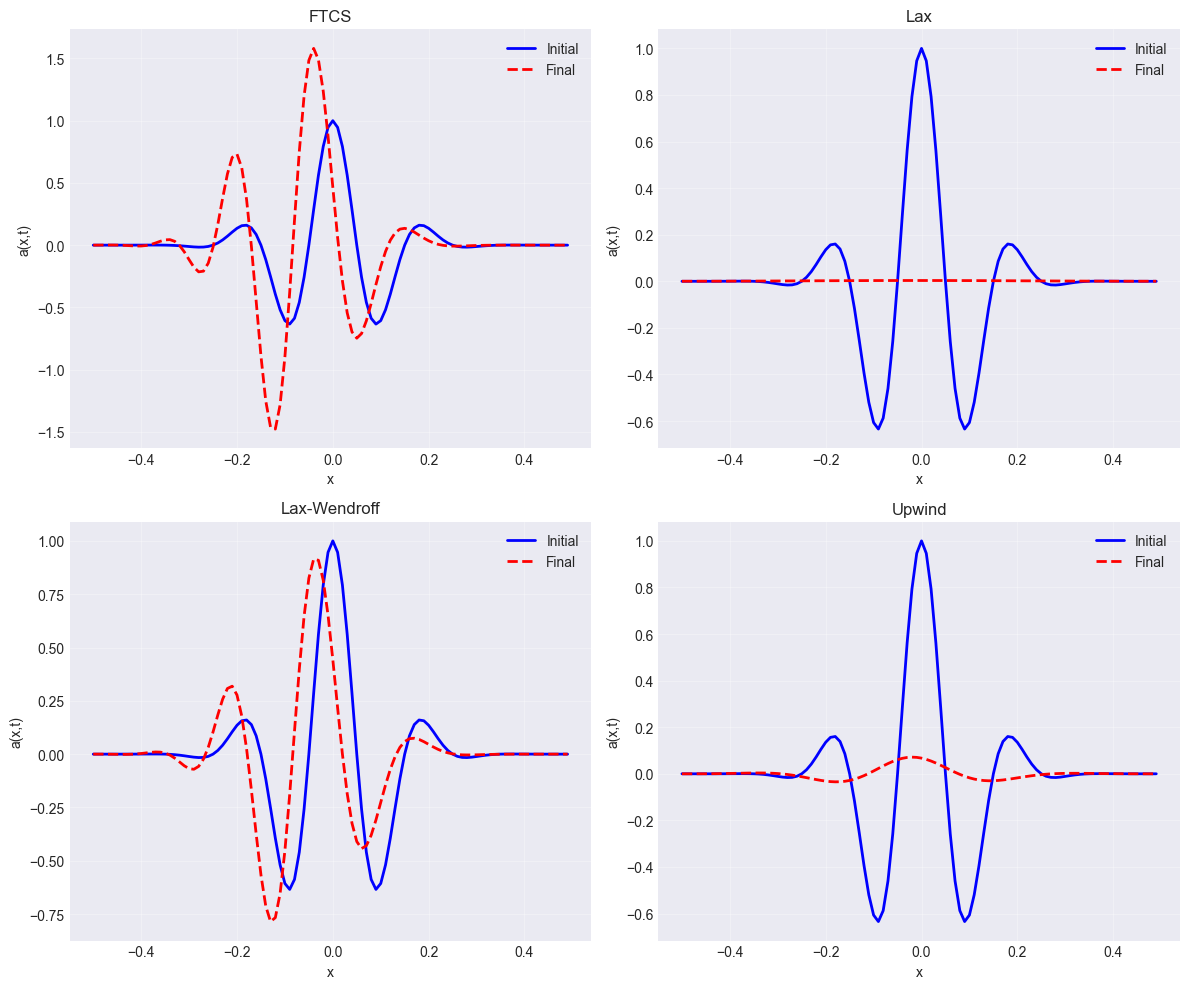


OBSERVATIONS:
FTCS: Shows oscillations and dissipation (unstable)
Lax: More dissipation than FTCS, fewer oscillations
Lax-Wendroff: Least dissipation, minimal oscillations (best)
Upwind: Stable but diffusive


In [3]:
# Fixed parameters
N = 100
L = 1.0
c = 1.0
tau = 0.001
nStep = 1000

method_names = ['FTCS', 'Lax', 'Lax-Wendroff', 'Upwind']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, method in enumerate([1, 2, 3, 4]):
    print(f"\n{'='*50}")
    print(f"Running {method_names[i]} method")
    print(f"{'='*50}")
    
    x, aplot, tplot, iplot = solve_advection(method, N, L, c, tau, nStep)
    
    axes[i].plot(x, aplot[:,0], 'b-', label='Initial', linewidth=2)
    axes[i].plot(x, aplot[:,iplot-1], 'r--', label='Final', linewidth=2)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('a(x,t)')
    axes[i].set_title(method_names[i])
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("OBSERVATIONS:")
print("="*50)
print("FTCS: Shows oscillations and dissipation (unstable)")
print("Lax: More dissipation than FTCS, fewer oscillations")
print("Lax-Wendroff: Least dissipation, minimal oscillations (best)")
print("Upwind: Stable but diffusive")

## 5. Effect of Grid Resolution (Lax Method)

Testing different grid resolutions with fixed time step:


Case A: N=50, τ=0.02
Time for wave to move one grid spacing: 0.0200
Wave circles system in 50.0 steps
CFL number: 1.0000

Case B: N=100, τ=0.02
Time for wave to move one grid spacing: 0.0100
Wave circles system in 50.0 steps
CFL number: 2.0000

Case C: N=200, τ=0.02
Time for wave to move one grid spacing: 0.0050
Wave circles system in 50.0 steps
CFL number: 4.0000


/var/folders/c6/n8tq18qd4ngcgfk73gs61cvm0000gn/T/ipykernel_24236/224469280.py:51: RuntimeWarning: overflow encountered in subtract
  a[:] = 0.5*(a[ip] + a[im]) + coeff*(a[ip] - a[im])
/var/folders/c6/n8tq18qd4ngcgfk73gs61cvm0000gn/T/ipykernel_24236/224469280.py:51: RuntimeWarning: overflow encountered in multiply
  a[:] = 0.5*(a[ip] + a[im]) + coeff*(a[ip] - a[im])
/var/folders/c6/n8tq18qd4ngcgfk73gs61cvm0000gn/T/ipykernel_24236/224469280.py:51: RuntimeWarning: invalid value encountered in add
  a[:] = 0.5*(a[ip] + a[im]) + coeff*(a[ip] - a[im])
/var/folders/c6/n8tq18qd4ngcgfk73gs61cvm0000gn/T/ipykernel_24236/224469280.py:51: RuntimeWarning: overflow encountered in add
  a[:] = 0.5*(a[ip] + a[im]) + coeff*(a[ip] - a[im])


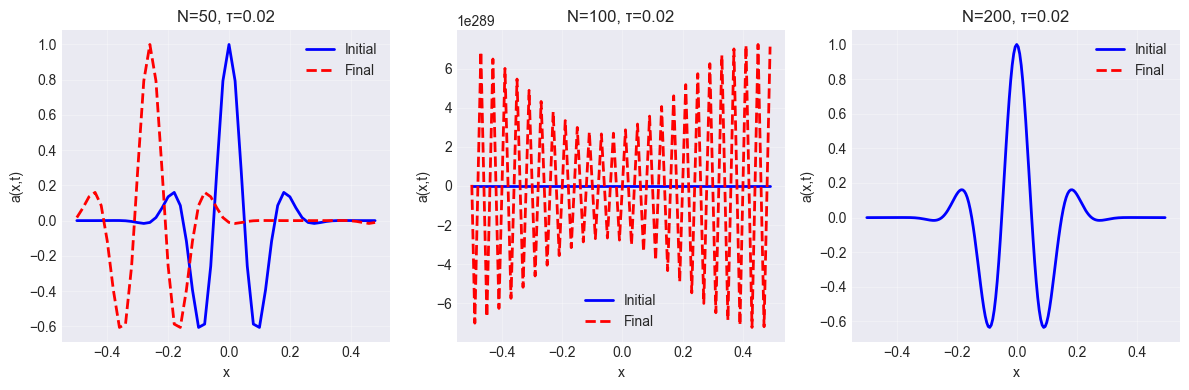


OPTIMAL CHOICE: N=50, τ=0.02
Reasons:
• Optimal resolution: Captures wave features without excessive diffusion
• Stable time-stepping: CFL ≈ 1.0 ensures stability
• Balanced accuracy-efficiency: Good balance between accuracy and speed


In [4]:
# Parameters from slides
cases = [
    {'N': 50, 'tau': 0.02, 'label': 'N=50, τ=0.02'},
    {'N': 100, 'tau': 0.02, 'label': 'N=100, τ=0.02'},
    {'N': 200, 'tau': 0.02, 'label': 'N=200, τ=0.02'}
]

L = 1.0
c = 1.0
nStep = 1000
method = 2  # Lax method

plt.figure(figsize=(12, 4))

for idx, case in enumerate(cases):
    print(f"\nCase {chr(65+idx)}: N={case['N']}, τ={case['tau']}")
    x, aplot, tplot, iplot = solve_advection(method, case['N'], L, c, case['tau'], nStep)
    
    plt.subplot(1, 3, idx+1)
    plt.plot(x, aplot[:,0], 'b-', label='Initial', linewidth=2)
    plt.plot(x, aplot[:,iplot-1], 'r--', label='Final', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('a(x,t)')
    plt.title(case['label'])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OPTIMAL CHOICE: N=50, τ=0.02")
print("="*60)
print("Reasons:")
print("• Optimal resolution: Captures wave features without excessive diffusion")
print("• Stable time-stepping: CFL ≈ 1.0 ensures stability")
print("• Balanced accuracy-efficiency: Good balance between accuracy and speed")

## 6. 3D Visualization

Visualize wave propagation over space and time:

Time for wave to move one grid spacing: 0.0100
Wave circles system in 100.0 steps
CFL number: 1.0000


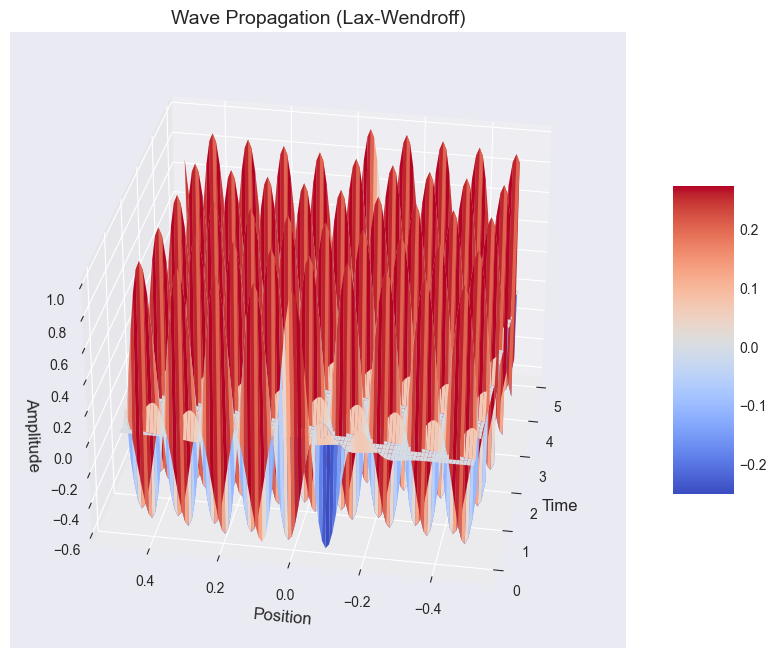

In [5]:
# Run Lax-Wendroff method for 3D plot
N = 100
L = 1.0
c = 1.0
tau = 0.01
nStep = 500

x, aplot, tplot, iplot = solve_advection(3, N, L, c, tau, nStep)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

Tp, Xp = np.meshgrid(tplot[0:iplot], x)
surf = ax.plot_surface(Tp, Xp, aplot[:,0:iplot], 
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

ax.view_init(elev=30., azim=190.)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Position', fontsize=12)
ax.set_zlabel('Amplitude', fontsize=12)
ax.set_title('Wave Propagation (Lax-Wendroff)', fontsize=14)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## 7. Summary

### Stability Conditions:
- **FTCS:** Unconditionally unstable for advection
- **Lax:** $|c\tau/h| \leq 1$ (CFL condition)
- **Lax-Wendroff:** Most accurate; same stability as Lax
- **Upwind:** $0 \leq c\tau/h \leq 1$

### Method Characteristics:
- **FTCS:** Simple but unstable
- **Lax:** Stable but diffusive
- **Lax-Wendroff:** Best accuracy, minimal dissipation
- **Upwind:** Stable but most diffusive

### Practical Considerations:
- Grid resolution vs. computational cost
- CFL condition for stability
- Numerical diffusion increases with coarser grids
- Periodic vs. Dirichlet boundary conditions affect grid spacing